In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
import os
import torchvision
from matplotlib import pyplot as plt 
from sklearn. metrics import f1_score
from tqdm import tqdm, tqdm_notebook
import math

In [2]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
len(MNIST_train.train_labels)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


60000

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


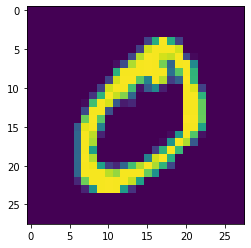

In [4]:
plt.imshow(MNIST_train.train_data[1]/255)

In [5]:
class make_data():
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.len = len(self.data)
        
    def __getitem__(self, index):
        img = self.data[index] 
        img = np.array(img)
        img = img.reshape((1,28,28))
        
        # нормализуем
        img = img / 255
        
        return img, int(self.labels[index])
    
    def __len__(self):
        return self.len
        

In [6]:
def custom_loader( dataset, num_batch):
        data = []
        amount = len(dataset) // num_batch
        for i in range(amount):
            batch_img = []
            batch_tar = []
            if i != amount:
                for j in range(num_batch):
                    batch_img.append(dataset[i*j][0])
                    batch_tar.append(dataset[i*j][1])
            else:
                for j in range(len(dataset)-amount*num_batch):
                    batch_img.append(dataset[i*j][0])
                    batch_tar.append(dataset[i*j][1])
            data.append((np.array(batch_img), np.array(batch_tar)))
        return data

свертка

In [7]:
class conv2d():
    def __init__(self, in_channels, out_channels, kernel_size, stride = 1, padding = None, bias = True):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weights = np.random.rand(self.out_channels, self.in_channels, *self.kernel_size)
        self.type = 'conv'
        if bias:
            self.bias = np.random.rand(out_channels)
        else: 
            self.bias = None
            
            
    # свертка    
    def __call__(self, input_img): 
        self.input = input_img
        if self.padding is not None:
            input_img = self.get_padding(input_img, pad = self.padding)
        out = self.calc_out_shape(self.input.shape, self.out_channels,self.kernel_size[0],self.stride,self.padding)
        output = np.zeros(out) 
        for i in range(out[0]): # по каждой из картиночек
            outs = output[i,:,:,:]
            for j in range(input_img.shape[1]): #по каждому каналу картиночки
                for k in range(out[2]): # по каждому пикселю высоты
                    arr = input_img[i,j, k*self.stride:k*self.stride+self.kernel_size[0],
                                          k*self.stride:k*self.stride+self.kernel_size[1]]
                    for m in range(out[1]): # по каждому каналу ядра
                        if self.bias is not None:
                            outs[m, k, k] += np.sum(arr * self.weights[m][j]) + self.bias[m]
                        else: 
                            outs[m, k, k] += np.sum(arr * self.weights[m][j])
            output[i,:,:,:] = outs
        return np.array(output)
    
    
    def __str__(self):
        return self.type
    
    
    # padding
    def get_padding(self, input, pad = 1, full = 0):
        # img size: n_batch, n_channels, w,h
        padd = []
        for i in range(input.shape[0]):
            arr = np.full((input.shape[1],input.shape[2]+2*pad,input.shape[3]+2*pad),full)
            arr[:, pad:-pad,pad:-pad] = input[i]
            padd.append(arr)
        return np.array(padd)

    # вычисляем выходную размерность
    def calc_out_shape(self, input_matrix_shape, out_channels, kernel_size, stride, padding):
        if padding == None:
            padding = 0
        out_shape = [input_matrix_shape[0], out_channels, (input_matrix_shape[2]+2*padding-kernel_size)//stride+1,
                 (input_matrix_shape[3]+2*padding-kernel_size)//stride+1] 
        return np.array(out_shape)
    
    def get_params(self):
        return [self.weights, self.bias]
    
    
    def update_weights(self, new_params):
        self.weight, self.bias = new_params
    
    
    def backward(self, prev_grad):
        dx = np.zeros_like(self.input) # dx = dy с 0-отступом, свернутый с «инвертированным» фильтром self.weights
        dw = np.zeros_like(self.weights) # dw = свертка сверткой входа self.input с фильтром dy
        db = np.zeros_like(self.bias)
        
        
        db = np.sum(prev_grad, axis = (0, 2, 3))
        
        N, C, H, W = self.input.shape
        F, _, HH, WW = self.weights.shape
        _, _, H_, W_ = prev_grad.shape
        
        w_ = np.zeros_like(dw)
        for i in range(HH):
            for j in range(WW):
                w_[:,:,i,j] = self.weights[:,:,HH-i-1,WW-j-1]
        if self.padding is not None:
            pad = self.padding
            input_w_pad = self.get_padding(self.input, pad = self.padding) 
            dx_w_pad = self.get_padding(dx, pad = self.padding) 
        else:
            pad = 0
            input_w_pad = self.input
            dx_w_pad = dx 
            
        pred_grad_w_pad =  self.get_padding(prev_grad, pad = WW-1) # реализация для квадратных изображений и ядер свертки
    
        for n in range(N):       
            for f in range(F):   
                for i in range(HH): 
                    for j in range(WW):
                        for k in range(H_): 
                            for l in range(W_):
                                for c in range(C): 
                                    dw[f,c,i,j] += input_w_pad[n, c, self.stride*i+k, self.stride*j+l] * prev_grad[n, f, k, l]
    
                for i in range(H+2*pad):
                    for j in range(W+2*pad):
                        for k in range(HH):
                            for l in range(WW):
                                for c in range(C): 
                                    dx_w_pad[n,c,i,j] += pred_grad_w_pad[n, f, i+k, j+l] * w_[f, c, k, l]
        if self.padding is not None:                            
            dx = dx_w_pad[:,:,pad:-pad,pad:-pad]
        else: dx = dx_w_pad
#         print(dw)
        return dx, dw, db        

In [8]:
#maxpool
class maxpool2d():
    def __init__(self,kernel_size, stride=None, padding=0, dilation=1):
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.type = 'maxpool'
        
    
    def __call__(self,input):
#         print('maxpool', input.shape)
        self.input = input
        if self.padding != 0:
            input = self.get_padding(input, self.padding)
        n = input.shape[0]
        c = input.shape[1]
        h = (input.shape[2]-self.kernel_size[0])//self.stride + 1
        w = (input.shape[3]-self.kernel_size[1])//self.stride + 1
        out_shape = [n, c, h, w]
        output = np.zeros(out_shape)
        for batch in range(n):
            f_row = self.kernel_size[0]
            f_col = self.kernel_size[1]
            for i in range(c):
                current_img = input[batch,i]
                for j in range(h):
                    for k in range(w):
                            output[batch, i, j, k] = np.max(current_img[j*self.stride: j*self.stride+f_row, k*self.stride: k*self.stride+f_col])             
        self.size = output.shape
        return output
    
    def __str__(self):
        return self.type
        
        
    def get_padding(self, input, pad = 1, full = 0):
        # img size: n_batch, n_channels, w,h
        padd = []
        for i in range(input.shape[0]):
            arr = np.full((input.shape[1],input.shape[2]+2*pad,input.shape[3]+2*pad),full)
            arr[:, pad:-pad,pad:-pad] = input[i]
            padd.append(arr)
        return np.array(padd)
    
    def backward(self, prev_grad):
        if prev_grad.shape != self.size:
            prev_grad = np.reshape(self.size)
        N, C, H, W =prev_grad.shape
        dx = np.zeros_like(self.input)
        
        for n in range(N):
            for c in range(C):
                for i in range(H):
                    for j in range(W):
                        i_t, j_t = np.where(np.max(self.input[n, c, i * self.stride : i * self.stride + self.kernel_size[0], j * self.stride : j * self.stride + self.kernel_size[1]]) == self.input[n, c, i * self.stride : i * self.stride + self.kernel_size[0], j * self.stride : j * self.stride + self.kernel_size[1]])
                        i_t, j_t = i_t[0], j_t[0]
                        dx[n, c, i * self.stride : i * self.stride + self.kernel_size[0], j * self.stride : j * self.stride + self.kernel_size[1]][i_t, j_t] = prev_grad[n, c, i, j]
        return dx

In [9]:
class linear():
    def __init__(self, in_features: int, out_features: int, bias = True):
        self.in_features = in_features
        self.out_features = out_features
        self.weight = np.random.rand(self.out_features, self.in_features)
        self.type = 'linear'
        
        if bias:
            self.bias = np.random.rand(self.out_features)
        else:
            self.bias = None
            
            
    def __call__(self, input):
        self.input = input
        result = []
        
        for i in range(input.shape[0]):
            summ = np.matmul(self.weight, input[i]) + self.bias
            result.append(summ)
        return np.array(result)
    
    def __str__(self):
        return self.type
    
    def get_params(self):
        return [self.weight, self.bias]
    
    def update_weights(self, new_params):
        self.weight, self.bias = new_params
    
    def backward(self,prev_grad):
        dw = np.dot(prev_grad.T, self.input)
        db = prev_grad.mean(axis=0, keepdims=True)
        db = db.reshape(db.shape[1])
        dx = np.dot(self.weight.T, prev_grad.T).T
        assert (dx.shape == self.input.shape)
        assert (dw.shape == self.weight.shape)
        assert (db.shape == self.bias.shape)
        return dx, dw, db
    

In [10]:
class relu():
    def __init__(self, inplace = False):
        self.inplace = inplace
        self.type = 'relu'
        
        
    def __call__(self, input):
        self.input = input
        result = []
        for i in range(input.shape[0]):
            result.append(np.maximum(0, input[i]))
        return np.array(result)
    
    
    def __str__(self):
        return self.type
    
    
    def backward(self, grad):
        grad = grad.reshape(self.input.shape)
        return np.where(self.input>0,grad,0)


class softmax():
    def __init__(self, dim):
        self.dim = dim
        self.type = 'softmax'
    
    def __str__(self):
        return self.type
    
    def __call__(self, input):
        y = np.exp(input - np.max(input, axis=self.dim, keepdims=True))
        return y / np.sum(y, axis=self.dim, keepdims=True)
    
    def backward(self, prev_grad):
        return prev_grad
        

In [11]:
def Flatten(input):
    new = []
    for i in range(input.shape[0]):
        new.append(input[i].flatten())
    return np.array(new)

In [12]:
# CrossEntropyLoss
class CELoss():
    def __init__(self):
        pass
    
    
    def __call__(self, y_pred, y_true):
         true_class_logits = y_pred[np.arange(len(y_pred)), y_true]
    
         cross_entropy = - true_class_logits + np.log(np.sum(np.exp(y_pred), axis=-1))
         return np.mean(cross_entropy)
        
        
    def backward(self, y_pred, y_true):
        ones_true_class = np.zeros_like(y_pred)
        ones_true_class[np.arange(len(y_pred)),y_true] = 1
        softmax = np.exp(y_pred) / np.exp(y_pred).sum(axis=-1,keepdims=True)
    
        return (-ones_true_class + softmax) / y_pred.shape[0]

In [13]:
class Adam():
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        self.params = np.array(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay
        
        self.steps = np.zeros(len(self.params))
        self.exp_avg = np.zeros_like(self.params)
        self.exp_avg_sq = np.zeros_like(self.params)
        
    def __call__(self,):
        pass
    
    def step(self, grads):
        for i in range(len(self.params)):
            grad = grads[i]  # получаем градиенты слоя модели
            
            if self.steps[i] == 0:
                # Momentum 
                self.exp_avg[i] = np.zeros_like(self.params[i])
                # RMS Prop componenet. 
                self.exp_avg_sq[i] = np.zeros_like(self.params[i])
                    
            self.steps[i] += 1
            if self.weight_decay != 0:
                    grad = grad.add(self.weight_decay, self.params[i])
            
            # Momentum
            self.exp_avg[i][0] = np.multiply(self.exp_avg[i][0], self.beta1) + (1 - self.beta1) * grad[0]
            self.exp_avg[i][1] = np.multiply(self.exp_avg[i][1], self.beta1) + (1 - self.beta1) * grad[1]
            # RMS
            self.exp_avg_sq[i][0] = np.multiply(self.exp_avg_sq[i][0], self.beta2) + (1-self.beta2)*(grad[0]*grad[0])
            self.exp_avg_sq[i][1] = np.multiply(self.exp_avg_sq[i][1], self.beta2) + (1-self.beta2)*(grad[1]*grad[1])
            
            self.exp_avg_sq[i][0] = self.exp_avg_sq[i][0].astype('float')
            self.exp_avg_sq[i][1] = self.exp_avg_sq[i][1].astype('float')
            
            denom_w = np.sqrt(self.exp_avg_sq[i][0]) + self.eps
            denom_b = np.sqrt(self.exp_avg_sq[i][1]) + self.eps

            bias_correction1 = 1 / (1 - self.beta1 ** self.steps[i])
            bias_correction2 = 1 / (1 - self.beta2 ** self.steps[i])
                
            adapted_learning_rate = self.lr * bias_correction1 / math.sqrt(bias_correction2)

            self.params[i][0] = self.params[i][0] - adapted_learning_rate * self.exp_avg[i][0] / denom_w
            self.params[i][1] = self.params[i][1] - adapted_learning_rate * self.exp_avg[i][1] / denom_b
        return self.params       
        

In [14]:
class model():
    def __init__(self, num_classes = 10):
        self.conv1 = conv2d(in_channels = 1, out_channels = 6, kernel_size = (5,5), padding = 2)
        self.relu1 = relu()
        self.maxpool1 = maxpool2d(kernel_size=(2, 2), stride=2)
        
        self.conv2 = conv2d(in_channels = 6, out_channels = 16, kernel_size = (5,5))
        self.relu2 = relu()
        self.maxpool2 = maxpool2d(kernel_size=(2, 2), stride=2)
        
        self.fc1 = linear(in_features=5*5*16, out_features=120)
        self.relu3 = relu()
        self.fc2 = linear(in_features=120, out_features=84)
        self.relu4 = relu()
        self.fc3 = linear(in_features=84, out_features=10)
        self.softmax = softmax(dim=1)
        
        self.layers_list = [self.conv1,self.relu1, self.maxpool1, 
                            self.conv2, self.maxpool2, self.relu2, 
                            self.fc1, self.relu3, self.fc2, self.relu4, self.fc3, self.softmax]
    
    def __call__(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        x = Flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        output = self.softmax(x)

        return output

    def get_backward(self, grad):
        lst = self.layers_list.copy()
        lst.reverse()
        grads = []
        for item in lst:
#             print(item.__str__() )
            if item.__str__() not in ['softmax', 'relu', 'maxpool']:
                grad, dw,db = item.backward(grad)
                grads.append([dw, db])
            else:
                grad = item.backward(grad)
        grads.reverse()        
        return grads
                
        
    def update_weights(self, new_params):
        i = 0
        for item in self.layers_list:
            if item.__str__() not in ['softmax', 'relu', 'maxpool']:
                item.update_weights(new_params[i])
                i+=1
    
    def get_params(self):
        params = []
        for item in self.layers_list:
            if item.__str__() not in ['softmax', 'relu', 'maxpool']:
                params.append(item.get_params())
        return params

In [15]:
class train():
    def __init__(self, model, data, n_epoch):
        self.model = model
        self.train_data, self.val_data = data
        self.n_epoch = n_epoch
        
        self.criterion = CELoss()
        self.opt = Adam(model.get_params() )
    
    def __call__(self):
        history = []
        log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} \
                                         train_acc {t_acc:0.4f} val_acc {v_acc:0.4f} \
                                         train_f1 {t_f1:0.4f} val_f1 {v_f1:0.4f}"
        with tqdm(desc="epoch", total=self.n_epoch) as pbar_outer:
            for epoch in range(self.n_epoch):
                train_loss, train_acc, train_f1 = self.fit()
            
                val_loss, val_acc, val_f1 = self.val()
                
                pbar_outer.update(1)
                history.append((train_loss, train_acc, val_loss, val_acc, train_f1, val_f1))
                tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,v_loss=val_loss, 
                                               t_acc=train_acc, v_acc=val_acc, 
                                               t_f1 = train_f1, v_f1 =val_f1))
        return history

    
    def fit(self):
            running_loss = 0.0
            running_corrects = 0
            processed_data = 0
            train_f1_score = []
            for inputs, labels in self.train_data:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels) # считаем loss
                print('loss', loss)
                
                grads = self.model.get_backward(self.criterion.backward(outputs, labels)) # считаем градиент loss функции и градиенты слоев модели
                self.model.update_weights(self.opt.step(grads))  # считаем шаг для обновления весов и обновляем их
                
                preds = np.argmax(outputs, 1)
                running_loss += loss * inputs.shape[0]
                running_corrects += np.sum(preds == labels.data)
                processed_data += inputs.shape[0]
                train_f1_score.append(f1_score(labels, preds, average='macro'))
              
            train_loss = running_loss / processed_data
            train_acc = running_corrects / processed_data
            train_f1 = np.average(train_f1_score)
            return train_loss, train_acc, train_f1
    
    def val(self):
            running_loss = 0.0
            running_corrects = 0
            processed_size = 0
            val_f1_score = []
        
            for inputs, labels in self.val_data:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                print('val_loss', loss)
                preds = np.argmax(outputs, 1)

                running_loss += loss * inputs.shape[0]
                running_corrects += np.sum(preds == labels)
                processed_size += inputs.shape[0]
                val_f1_score.append(f1_score(labels, preds, average='macro'))
            val_loss = running_loss / processed_size
            val_acc = running_corrects / processed_size
            val_f1 = np.average(val_f1_score)
            return val_loss, val_acc, val_f1

In [16]:
datas1 = make_data(MNIST_train.train_data[:500], MNIST_train.train_labels[:500])
train_dataset = custom_loader(datas1, 100)
datas2 = make_data(MNIST_train.test_data[:100], MNIST_train.test_labels[:100])
val_dataset = custom_loader(datas2, 10)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
lenet = model()
start_train = train(lenet, (train_dataset, val_dataset), n_epoch = 5)
his = start_train()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 2.4611501717344746
loss 2.4011501717344745
loss 2.3711501717344747
loss 2.3811501717344745
loss 2.3611501717344745
val_loss 2.4611501717344746
val_loss 2.3611501717344745
val_loss 2.3611501717344745
val_loss 2.4611501717344746
val_loss 2.2611501717344744
val_loss 2.2611501717344744
val_loss 2.4611501717344746
val_loss 2.3611501717344745
val_loss 2.3611501717344745


epoch:  20%|██        | 1/5 [26:22<1:45:31, 1582.85s/it]

val_loss 2.4611501717344746

Epoch 001 train_loss: 2.3952                                          val_loss 2.3812                                          train_acc 0.0660                                          val_acc 0.0800                                          train_f1 0.0122                                          val_f1 0.0203
loss 2.4611501717344746
loss 2.4011501717344745
loss 2.3711501717344747
loss 2.3811501717344745
loss 2.3611501717344745


In [ ]:
loss, acc, val_loss, val_acc, tr_f1, val_f1= zip(*his)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 25))
axs[0, 0].plot(loss, label="train")
axs[0, 0].plot(val_loss, label="val")
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel("epochs")
axs[0, 0].set_ylabel("loss")
axs[0, 0].legend()
axs[0, 1].plot(acc, label="train")
axs[0, 1].plot(val_acc, label="val")
axs[0, 1].set_title('Accuracy')
axs[0, 1].set_xlabel("epochs")
axs[0, 1].set_ylabel("loss")
axs[0, 1].legend()
axs[0, 2].plot(tr_f1, label="ADAM")
axs[0, 2].plot(val_f1, label="ADASMOOTH")
axs[0, 2].set_title('f1-score')
axs[0, 2].set_xlabel("epochs")
axs[0, 2].set_ylabel('accuracy')
axs[0, 2].legend()
plt.savefig('gc.jpg')
plt.show()